# Boston Vaccination Research 

In [9]:
from census import Census
from us import states

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [ ]:
# Replace YOUR_API_KEY with your actual API key
API_KEY = "aeca2098dcfc8374d3603b771c156c791c87be50"
c = Census(API_KEY, year=2020)  # Use appropriate year

In [19]:
# Interested variables
variables = {
    'B01001_001E': 'Total Population',
}

# Fetch data for Bristol County (for New Bedford)
data_bristol = c.acs5.state_county(list(variables.keys()), states.MA.fips, '005')  # 005 is the FIPS for Bristol County

print(f"Data for Bristol County (New Bedford is a part of this):")
for key, label in variables.items():
    value = data_bristol[0][key]
    print(f"{label}: {value}")

# Fetch data for Norfolk County (for Wellesley)
data_norfolk = c.acs5.state_county(list(variables.keys()), states.MA.fips, '021')  # 021 is the FIPS for Norfolk County

print(f"\nData for Norfolk County (Wellesley is a part of this):")
for key, label in variables.items():
    value = data_norfolk[0][key]
    print(f"{label}: {value}")


Data for Bristol County (New Bedford is a part of this):
Total Population: 563301.0

Data for Norfolk County (Wellesley is a part of this):
Total Population: 703740.0


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you've already fetched the data from the previous steps
data_list = []
places = [('New Bedford', 'city'), ('Wellesley', 'town')]



/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_27782/3414736362.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['County'], y=df['Below Poverty Level (%)'], ax=axes[0, 0], palette=colors)
/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_27782/3414736362.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['County'], y=df['Population Over 65 (%)'], ax=axes[0, 1], palette=colors)
/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_27782/3414736362.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x

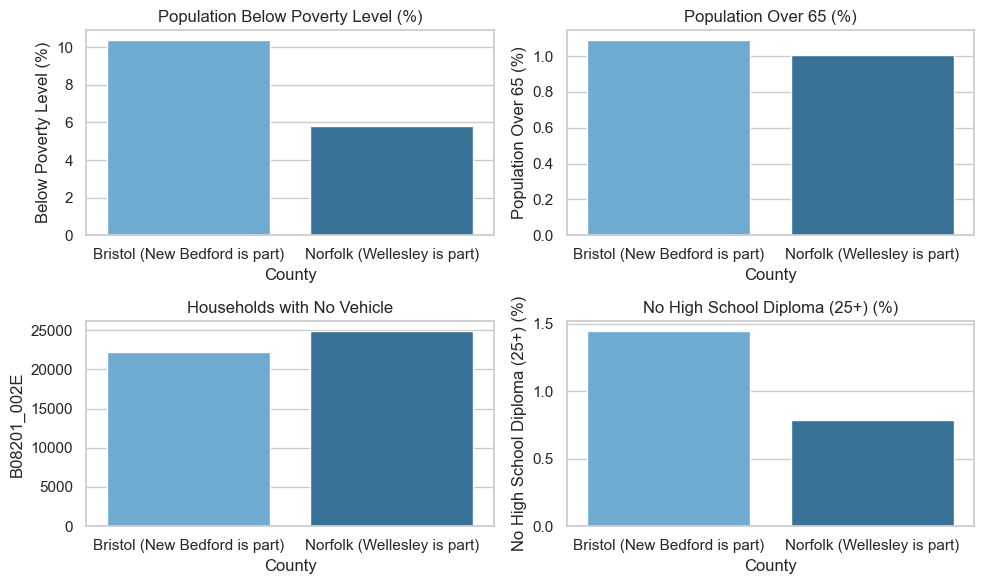

In [25]:
# Variables related to social vulnerability
variables = {
    'B01001_001E': 'Total Population',
    'B17001_002E': 'Below Poverty Level',
    'B01001_020E': 'Population Over 65',
    'B08201_002E': 'Households with No Vehicle',
    'B15003_002E': 'No High School Diploma (25+)',
}

# Fetch data for Bristol and Norfolk counties
data_bristol = c.acs5.state_county(list(variables.keys()), states.MA.fips, '005')
data_norfolk = c.acs5.state_county(list(variables.keys()), states.MA.fips, '021')

# Convert the data to a DataFrame for easier visualization
df = pd.DataFrame([data_bristol[0], data_norfolk[0]])
df['County'] = ['Bristol (New Bedford is part)', 'Norfolk (Wellesley is part)']

# Convert raw counts to percentages where it makes sense (like below poverty level, etc.)
df['Below Poverty Level (%)'] = (df['B17001_002E'] / df['B01001_001E']) * 100
df['Population Over 65 (%)'] = (df['B01001_020E'] / df['B01001_001E']) * 100
df['No High School Diploma (25+) (%)'] = (df['B15003_002E'] / df['B01001_001E']) * 100

# Set up the color palette with two shades of blue
colors = ["#5DADE2", "#2874A6"]

# Visualization
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

sns.barplot(x=df['County'], y=df['Below Poverty Level (%)'], ax=axes[0, 0], palette=colors)
axes[0, 0].set_title('Population Below Poverty Level (%)')

sns.barplot(x=df['County'], y=df['Population Over 65 (%)'], ax=axes[0, 1], palette=colors)
axes[0, 1].set_title('Population Over 65 (%)')

sns.barplot(x=df['County'], y=df['B08201_002E'], ax=axes[1, 0], palette=colors)
axes[1, 0].set_title('Households with No Vehicle')

sns.barplot(x=df['County'], y=df['No High School Diploma (25+) (%)'], ax=axes[1, 1], palette=colors)
axes[1, 1].set_title('No High School Diploma (25+) (%)')

plt.tight_layout()
plt.show()

In [4]:

# import the data from provided resources
vac_data = pd.read_csv("./data/COVID-vaccine_city_age.csv")

In [7]:
vac_data

,date,county,city,age_group,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated
0,2021-03-09,Barnstable,Barnstable,0-19 Years,8079.0,62.0,30.0,NaN,NaN,NaN,32.0
1,2021-03-09,Barnstable,Barnstable,20-29 Years,4924.0,576.0,395.0,NaN,NaN,NaN,181.0
2,2021-03-09,Barnstable,Barnstable,30-49 Years,8943.0,1714.0,1221.0,NaN,NaN,NaN,493.0
3,2021-03-09,Barnstable,Barnstable,50-64 Years,10997.0,2565.0,1561.0,NaN,NaN,NaN,1004.0
4,2021-03-09,Barnstable,Barnstable,65-74 Years,7032.0,3665.0,852.0,NaN,NaN,NaN,2813.0
...,...,...,...,...,...,...,...,...,...,...,...
335976,2023-04-18,Worcester,Worcester,30-49 Years,54952.0,7162.0,5544.0,1465.0,NaN,NaN,NaN
335977,2023-04-18,Worcester,Worcester,50-64 Years,36018.0,34345.0,30753.0,9587.0,NaN,NaN,NaN
335978,2023-04-18,Worcester,Worcester,65-74 Years,15432.0,17705.0,16243.0,7495.0,NaN,NaN,NaN
335979,2023-04-18,Worcester,Worcester,75+ Years,11563.0,13659.0,12321.0,5986.0,NaN,NaN,NaN


/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_29794/3192145396.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['vaccination_rate'] = (df_filtered['fully_vaccinated'] / df_filtered['population']) * 100


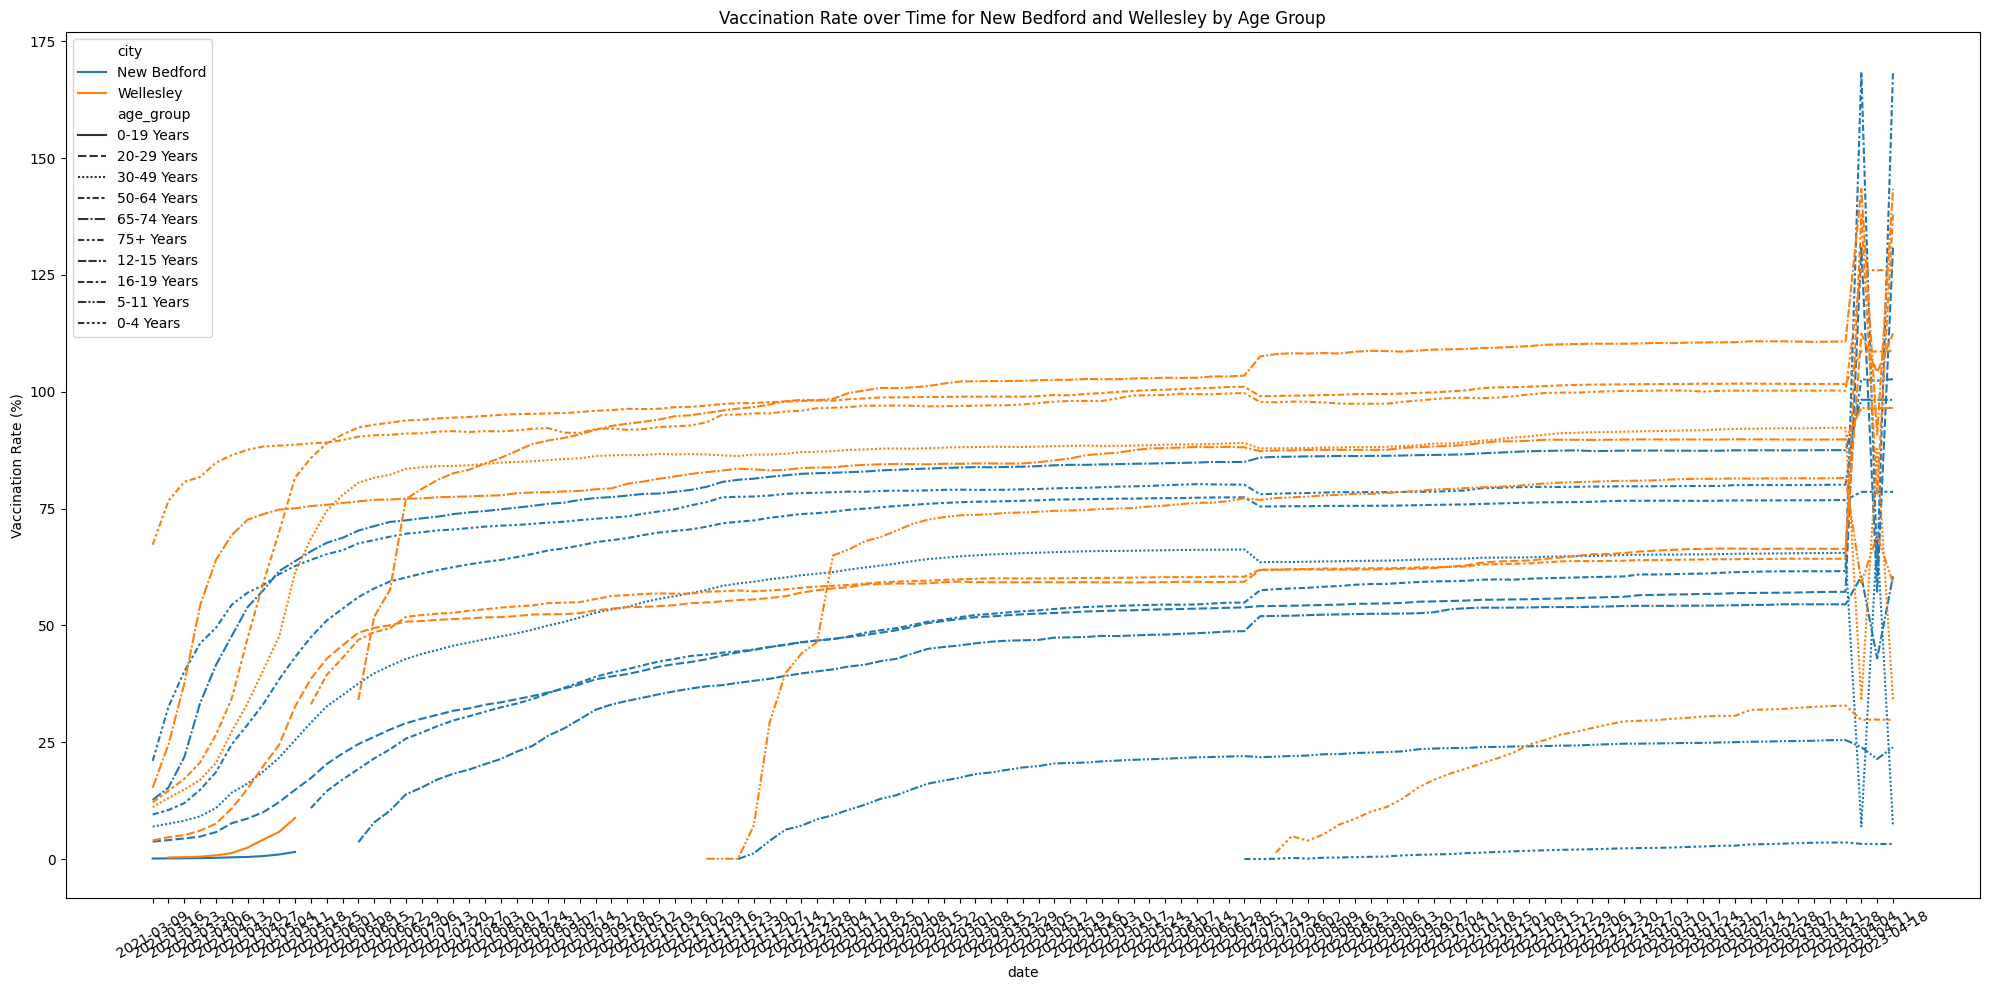

In [14]:
import matplotlib.dates as mdates

# Filtering data for New Bedford and Wellesley
df_filtered = vac_data[vac_data['city'].isin(['New Bedford', 'Wellesley'])]

# Calculating vaccination rate
df_filtered['vaccination_rate'] = (df_filtered['fully_vaccinated'] / df_filtered['population']) * 100

# Filtering out the 'Total' age group for a clearer plot, but you can include it if you prefer
df_filtered = df_filtered[df_filtered['age_group'] != 'Total']


# Plotting
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='age_group')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Vaccination Rate over Time for New Bedford and Wellesley by Age Group')
plt.ylabel('Vaccination Rate (%)')
plt.tight_layout()
plt.show()

In [ ]:
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)